In [14]:
import torch
from torch import nn
from torch.nn import functional as F
import pandas as pd
import numpy as np
import torchaudio

In [15]:
config = {
    "dataset": {
        "train": {
            "table": "./data/train.csv",
            "data": "./data/bare_data/"
        },
        "val": {
            "table": "./data/val.csv",
            "data": "./data/bare_data/"
        }
    },
    "train": {
        "batch_size": 1024,
        "grad_acum": 1,
        "dtype": "float32",
        'shuffle': True,
        'pin_memory': True,
    },
    "val": {
        "batch_size": 1024,
        "grad_acum": 1,
        "dtype": "float32",
        'shuffle': False,
        'pin_memory': True,
    },
    "vae": {
        "freq": 16000,
        "lenght": 5,
    },
    "model": {
        "latent_size": 128,
        "freq_scale": 4,
        "time_scale": 4,
    },
    "utils": {
        "n_fft": 800, # TODO
    }
}

In [19]:
class VAE_Audio(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_input = nn.Sequential(
            nn.Conv2d(1, 1, 1), nn.Sigmoid(),

            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(),
            nn.GELU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
        )

        # self.encoder_main = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
        #     nn.GELU(),
        #     nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1),
        #     nn.GELU(),
        #     nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1),
        #     nn.GELU(),
        #     nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1),
        #     nn.GELU(),
        # )
        
        self.encoder_squeeze = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),  
        )
        
        self.encoder_mu = nn.Conv2d(64, 64, 1)
        self.encoder_logvar = nn.Conv2d(64, 64, 1)

        self.decoder_unsqueeze = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), 
        )

        self.decoder_output = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.GELU(),
            nn.LazyBatchNorm2d(),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder_input(x)
        x = self.encoder_squeeze(x)
        mu = self.encoder_mu(x)
        logvar = self.encoder_logvar(x)
        return mu, logvar

    def sample(self, x):
        mu, logvar = self.encode(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z, mu, logvar

    def decode(self, z):
        z = self.decoder_unsqueeze(z)
        return self.decoder_output(z)

    def KLD_loss(self, mu, logvar, q=0.02):
        kld = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        kld = torch.clamp(kld, min=q)
        return kld.mean()


    def forward(self, x):
        z, mu, logvar = self.sample(x)
        return self.decode(z), z, mu, logvar

In [13]:
! mkdir train

In [20]:
from tqdm.auto import tqdm

class AvegereMeter:
    def __init__(self,):
        self.arr = []
    def __call__(self, item, n=1):
        if n<=1:
            self.arr.extend([item])
        else:
            self.arr.extend([item]*n)
    def __str__(self,) -> str:
        return str(np.mean(np.array(self.arr)))
    def zero(self,):
        self.arr=[]

class VAE_Trainer:
    def __init__(self, model, train_dataloader, val_dataloader,):
        self.model = model
        self.tdl = train_dataloader
        self.vdl = val_dataloader
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        self.rec_loss = nn.MSELoss()
        self.loss_meter = AvegereMeter()
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.5)

    def train_loop(self, k=0.01):
        self.model.train()
        self.loss_meter.zero()
        for batch in tqdm(self.tdl):
            with torch.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                audio, _ = batch
                z, mu, logvar = self.model.sample(audio)
                output = self.model.decode(z)
                loss = self.rec_loss(output, audio)+k*self.model.KLD_loss(mu, logvar)
            loss.backward()
            self.loss_meter(loss.item(), audio.shape[0])
            self.optimizer.step()
            self.optimizer.zero_grad()
        self.scheduler.step()
        print("Loss = "+self.loss_meter.__str__())

    def save_image(self, audio, output, iter = 0):
        idx = torch.randint(0, audio.shape[0], (1,)).item()
        input_tensor = audio[idx].cpu().detach().clamp(0, 1).to(torch.float32)
        output_tensor = output[idx].cpu().detach().clamp(0, 1).to(torch.float32)
    
        transform = transforms.ToPILImage('RGB')
        input_image = transform(torch.cat([input_tensor]*3, dim=0))
        output_image = transform(torch.cat([output_tensor]*3, dim=0))
    
        input_image.save(f'./train/input_{iter}.png')
        output_image.save(f'./train/output_{iter}.png')

    def val_loop(self):
        self.model.eval()
        self.loss_meter.zero()
        flag = 1
        for batch in tqdm(self.vdl):
            with torch.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                audio, _ = batch
                z, mu, logvar = self.model.sample(audio)
                output = self.model.decode(z)
                loss = self.rec_loss(output, audio)
                if (flag): 
                  self.save_image(audio, output, i)
                flag = 0
                self.loss_meter(loss.item(), audio.shape[0])
        print("Val loss = "+self.loss_meter.__str__())


In [ ]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

vae = VAE_Audio()

transform = transforms.Compose([transforms.ToTensor()])
train_ds = torchvision.datasets.MNIST('./data', train=True,  download=True, transform=transform)
val_ds   = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)
train_dataloader = DataLoader(train_ds, batch_size=config['train']['batch_size'], shuffle=True,  num_workers=2, pin_memory=config['train']['pin_memory'])
val_dataloader   = DataLoader(val_ds,   batch_size=config['val']['batch_size'], shuffle=False, num_workers=2, pin_memory=config['val']['pin_memory'])
trainer = VAE_Trainer(vae, train_dataloader, val_dataloader)
trainer = VAE_Trainer(vae, train_dataloader, val_dataloader)


# i = 0
# for epoch in tqdm(range(30)):
#     i += 1
#     trainer.train_loop(0.01)
#     trainer.val_loop()
# torch.save(vae.state_dict(), "vae.pt")


In [22]:
torch.save(vae.state_dict(), "vae.pt")

In [28]:
!  python3.10 -m pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 2.1 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 2.7 MB/s eta 0:00:0000:0100:01


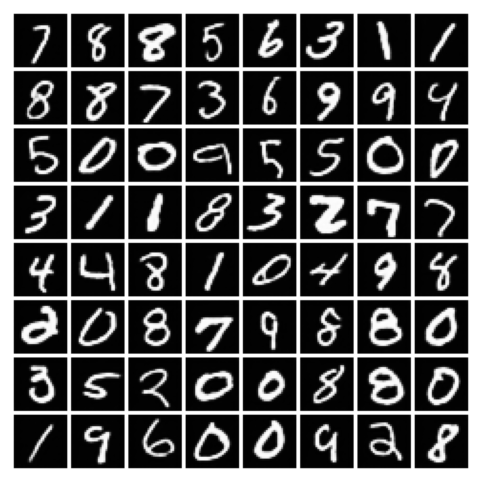

Готово: posterior_random_samples.png


In [78]:
import torch, matplotlib.pyplot as plt, torchvision.utils as vutils
vae = VAE_Audio()
vae.load_state_dict(torch.load("vae.pt", map_location='cpu'))
vae.eval()

mu_bank, std_bank = [], []
with torch.no_grad():
    for x, _ in train_dataloader:
        mu, logvar = vae.encode(x)
        mu_bank.append(mu)
        std_bank.append((0.5*logvar).exp())
        if len(mu_bank) * x.size(0) >= 10_000: 
            break

mu_bank  = torch.cat(mu_bank)   # (10k,64,7,7)
std_bank = torch.cat(std_bank)  # (10k,64,7,7)

idx   = torch.randint(0, mu_bank.size(0), (64,))
mu_s  = mu_bank[idx]            # (64,64,7,7)
std_s = std_bank[idx]

z = mu_s + 0.1 * std_s * torch.randn_like(mu_s)

with torch.no_grad():
    imgs = vae.decode(z)    # (64,1,28,28)

grid = vutils.make_grid(imgs, nrow=8, pad_value=1)
plt.figure(figsize=(6,6)); plt.axis('off')
plt.imshow(grid.permute(1,2,0)); plt.show()

vutils.save_image(imgs, 'posterior_random_samples.png', nrow=8)
print("Готово: posterior_random_samples.png")

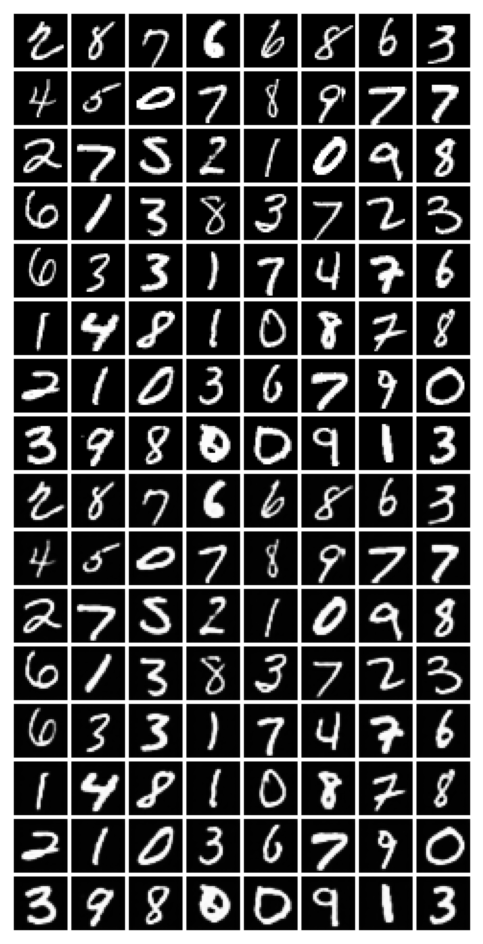

Готово: originals_and_generated.png


In [80]:
import torch, matplotlib.pyplot as plt, torchvision.utils as vutils

vae = VAE_Audio()
vae.load_state_dict(torch.load("vae.pt", map_location='cpu'))
vae.eval()

mu_bank, std_bank, x_bank = [], [], []

with torch.no_grad():
    for x, _ in train_dataloader:
        mu, logvar = vae.encode(x)
        mu_bank.append(mu)
        std_bank.append((0.5 * logvar).exp())
        x_bank.append(x)
        if len(mu_bank) * x.size(0) >= 10_000:
            break

mu_bank  = torch.cat(mu_bank)    # (10k,64,7,7)
std_bank = torch.cat(std_bank)   # (10k,64,7,7)
x_bank   = torch.cat(x_bank)     # (10k,1,28,28)

# Сэмплируем 64 случайных латента и соответствующие изображения
idx      = torch.randint(0, mu_bank.size(0), (64,))
mu_s     = mu_bank[idx]          # (64,64,7,7)
std_s    = std_bank[idx]
x_sampled = x_bank[idx]          # (64,1,28,28)

# Сэмплируем z ~ N(mu, 0.1 * std)
z = mu_s + 0.1 * std_s * torch.randn_like(mu_s)

with torch.no_grad():
    imgs = vae.decode(z)         # (64,1,28,28)

# Собираем изображение: сначала оригиналы, потом генерации
comparison = torch.cat([x_sampled, imgs], dim=0)  # (128,1,28,28)

# Сетка 8 на 16 (2 строки по 8 картинок)
grid = vutils.make_grid(comparison, nrow=8, pad_value=1)

plt.figure(figsize=(6, 12))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0), cmap='gray', vmin=0, vmax=1)
plt.show()

vutils.save_image(comparison, 'originals_and_generated.png', nrow=8)
print("Готово: originals_and_generated.png")


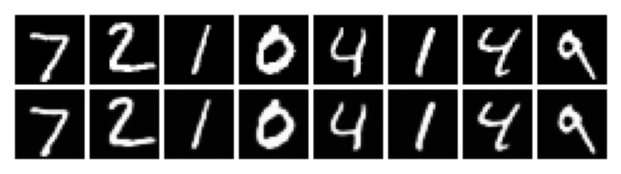

In [74]:
import torchvision.utils as vutils, matplotlib.pyplot as plt
imgs, _ = next(iter(val_dataloader))

with torch.no_grad():
    mu, _   = vae.encode(imgs)                     # ← 1× вызов encode
    recon   = vae.decode(mu)       # 28×28

grid = vutils.make_grid(
    torch.cat([imgs.cpu()[:8], recon.cpu()[:8]]),  # верх/низ
    nrow=8, pad_value=1
)
plt.figure(figsize=(8,2)); plt.axis('off')
plt.imshow(grid.permute(1,2,0)); plt.show()

In [68]:
! python3.10 -m pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 6.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 4.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 KB 5.6 MB/s eta 0:00:00a 0:00:01


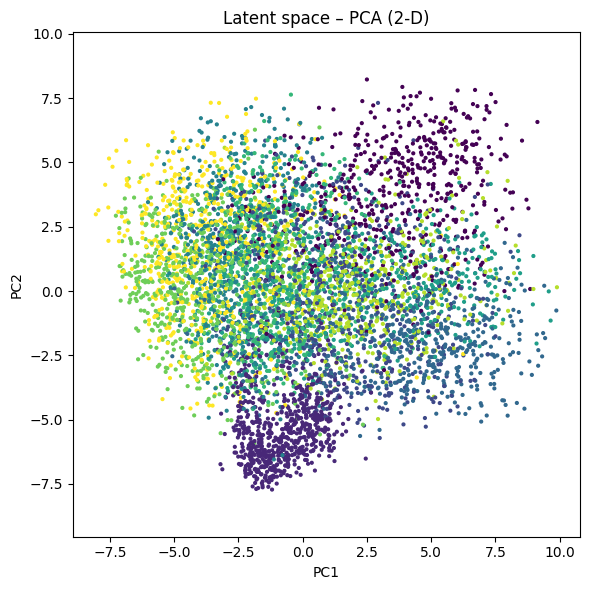

/home/kuli/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


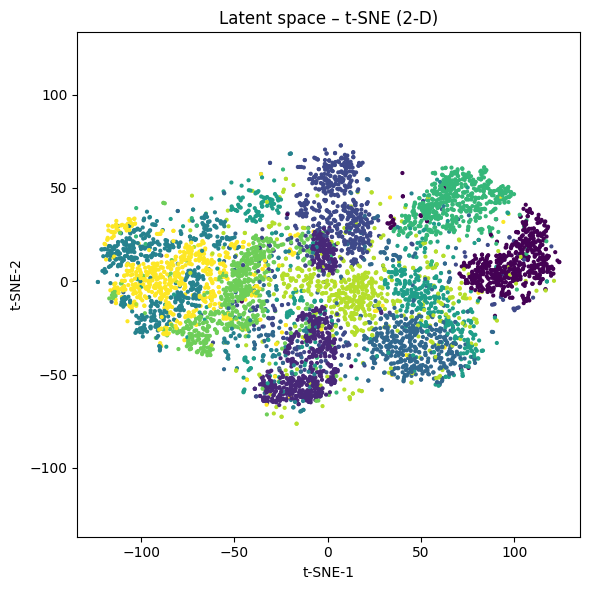

In [71]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae = VAE_Audio().to(device)
vae.load_state_dict(torch.load("vae.pt", map_location=device))
vae.eval()
latents, labels = [], []
with torch.no_grad():
    for x, y in val_dataloader:
        mu, _ = vae.encode(x.to(device))              # (B, C, 7, 7)
        latents.append(mu.view(mu.size(0), -1).cpu()) # → (B, C*7*7)
        labels.extend(y.numpy())
        if len(labels) >= 6000:                       # хватит 6k точек
            break

Z = torch.cat(latents)[:6000].numpy()
labels = np.array(labels)[:6000]

# --- 2.  PCA-проекция -------------------------------------------------------
Z_pca = PCA(n_components=2).fit_transform(Z)

plt.figure(figsize=(6,6))
plt.scatter(Z_pca[:,0], Z_pca[:,1], s=4, c=labels)
plt.title('Latent space – PCA (2-D)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.axis('equal'); plt.tight_layout(); plt.show()

# --- 3.  t-SNE-проекция -----------------------------------------------------
Z_tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='pca').fit_transform(Z)

plt.figure(figsize=(6,6))
plt.scatter(Z_tsne[:,0], Z_tsne[:,1], s=4, c=labels)
plt.title('Latent space – t-SNE (2-D)')
plt.xlabel('t-SNE-1'); plt.ylabel('t-SNE-2')
plt.axis('equal'); plt.tight_layout(); plt.show()

In [85]:
! git add VAE_mnist.ipynb

In [ ]:
! git push

Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 8 threads
Compressing objects: 100% (3/3), done.
Writing objects:  66% (2/3)